In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualisation
import tensorflow as tf


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['year_prediction.csv']


In [35]:
data = pd.read_csv("../input/year_prediction.csv")
data = data.rename(index=str, columns={"label":"year"})

We plot a histogram to understand how evenly spread the data is by viewing number of songs we have for a given year.

Text(0, 0.5, 'Number of songs')

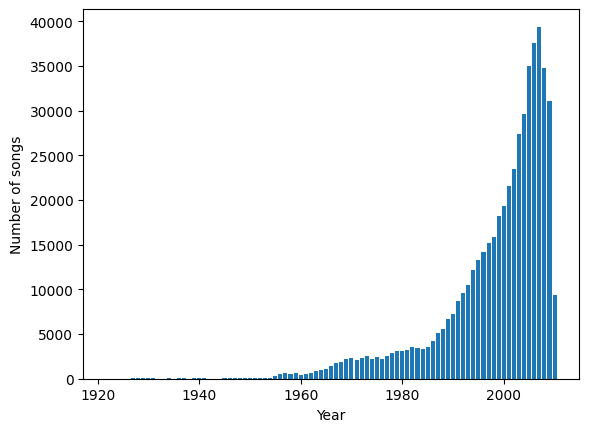

In [36]:
nsongs = {}
for y in range(1922,2012):
    nsongs[y] = len(data[data.year==y])
yrs = range(1922,2011)
values = [nsongs[y] for y in yrs]
plt.bar(yrs, values, align='center')
plt.xlabel("Year")
plt.ylabel("Number of songs")

In [37]:
# separate input attributes and output into different dataframes
X = data.iloc[:,1:]
Y = data.iloc[:,0]

# Train set
X_train = X.iloc[0:463715,:]
y_train = Y.iloc[0:463715]

# Validation set
X_test = X.iloc[463715:,:]
y_test = Y.iloc[463715:]


Each of the features takes a wide range of different values and distributions.

We apply MinMax scaling to our data.

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the train set and the test set.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled,columns=X_train.columns)

In [39]:
X_train.describe()

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
count,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,...,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000
mean,0.691393,0.469181,0.496357,0.350035,0.395117,0.358260,0.515310,0.397887,0.477290,0.426607,...,0.354631,0.487984,0.368845,0.657332,0.568014,0.466481,0.600205,0.343815,0.503517,0.347715
std,0.100947,0.071570,0.056527,0.036814,0.051474,0.063671,0.040431,0.044802,0.038783,0.063964,...,0.025093,0.019768,0.024255,0.019886,0.026819,0.016738,0.024350,0.019045,0.012446,0.023989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.634471,0.431166,0.464150,0.328296,0.363307,0.314100,0.492040,0.371622,0.455227,0.384236,...,0.340913,0.480545,0.356429,0.648426,0.556221,0.459283,0.589716,0.333782,0.498175,0.336685
50%,0.705958,0.479041,0.499274,0.345928,0.396288,0.350109,0.516244,0.398215,0.477664,0.425654,...,0.349484,0.490259,0.366313,0.656434,0.568816,0.466181,0.600938,0.341908,0.502698,0.346333
75%,0.765257,0.517551,0.530164,0.367222,0.427238,0.393690,0.539991,0.424327,0.500152,0.468346,...,0.362847,0.497755,0.378403,0.665694,0.581546,0.473821,0.611202,0.351684,0.507992,0.356798
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


90 features is lot of features and so we attempt dimensionality reduction by implementing PCA.

# PCA

First we normalise our data using scikits StandardScalar.
This is a necessary step for pca:
> Principle Component Analysis (PCA) as being a prime example of when normalization is important. In PCA we are interested in the components that maximize the variance. If one component (e.g. human height) varies less than another (e.g. weight) because of their respective scales (meters vs. kilos), PCA might determine that the direction of maximal variance more closely corresponds with the ‘weight’ axis, if those features are not scaled. As a change in height of one meter can be considered much more important than the change in weight of one kilogram, this is clearly incorrect.
(https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py)

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the train set and the test set.
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [41]:
X_train_std = pd.DataFrame(X_train_std,columns=X_train.columns)
X_train_std.describe()

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
count,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,...,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05
mean,7.593383e-16,-2.120864e-15,1.793384e-16,-1.326988e-15,-4.544139e-16,2.359042e-15,-5.413863e-16,4.538010e-16,-3.742449e-16,1.892860e-15,...,2.297199e-16,7.509414e-16,-4.726175e-15,-1.085286e-15,-4.592805e-15,-8.187235e-15,-2.577913e-15,-1.885015e-15,-7.515972e-15,4.761417e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-6.849083e+00,-6.555536e+00,-8.780881e+00,-9.508272e+00,-7.675981e+00,-5.626720e+00,-1.274530e+01,-8.881098e+00,-1.230653e+01,-6.669490e+00,...,-1.413267e+01,-2.468577e+01,-1.520687e+01,-3.305562e+01,-2.117983e+01,-2.786972e+01,-2.464943e+01,-1.805304e+01,-4.045652e+01,-1.449495e+01
25%,-5.638876e-01,-5.311584e-01,-5.697513e-01,-5.905186e-01,-6.179717e-01,-6.935698e-01,-5.755554e-01,-5.862542e-01,-5.688679e-01,-6.624309e-01,...,-5.466954e-01,-3.763002e-01,-5.118673e-01,-4.478800e-01,-4.397373e-01,-4.299846e-01,-4.307504e-01,-5.268242e-01,-4.292140e-01,-4.598088e-01
50%,1.442775e-01,1.377638e-01,5.161888e-02,-1.115648e-01,2.275066e-02,-1.280171e-01,2.309700e-02,7.320083e-03,9.665689e-03,-1.489907e-02,...,-2.051342e-01,1.151222e-01,-1.043898e-01,-4.517888e-02,2.990574e-02,-1.788398e-02,3.008970e-02,-1.001326e-01,-6.574410e-02,-5.763047e-02
75%,7.317100e-01,6.758454e-01,5.980758e-01,4.668744e-01,6.240130e-01,5.564446e-01,6.104375e-01,5.901695e-01,5.894924e-01,6.525343e-01,...,3.273959e-01,4.942984e-01,3.940738e-01,4.204911e-01,5.045541e-01,4.385694e-01,4.516087e-01,4.131805e-01,3.595684e-01,3.786469e-01
max,3.057122e+00,7.416766e+00,8.909792e+00,1.765551e+01,1.175114e+01,1.007897e+01,1.198797e+01,1.343956e+01,1.347767e+01,8.964296e+00,...,2.571906e+01,2.590152e+01,2.602152e+01,1.723191e+01,1.610766e+01,3.187494e+01,1.641892e+01,3.445501e+01,3.989141e+01,2.719132e+01


Our values are normalised and so we now actually apply PCA
(https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)

In [42]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.90)

# We fit to only our training set
pca.fit(X_train_std)
# Print number of components generated
pca.n_components_

55

PCA(.90) means that scikit-learn choose the minimum number of principal components such that 90% of the variance is retained.

In this case, 90% of the variance amounts to 55 principal components.

In [43]:
X_train_proc = pca.transform(X_train_std)
X_test_proc = pca.transform(X_test_std)

/Users/mountaintop/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [44]:
y_train_proc = y_train - min(y_train)
y_test_proc = y_test - min(y_test)
# y_train_proc

# Neural Network

In [45]:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Lambda, Dropout
# from tensorflow.python.keras.initializers import Initializer
# from tensorflow.python.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [46]:
y_train_hot = to_categorical(y_train_proc, 90)
y_test_hot = to_categorical(y_test_proc, 90)

In [47]:
print(X_train_proc.shape)
print(y_test_hot.shape)

(463715, 55)
(51630, 90)


In [48]:
def plot(history):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['mean_absolute_error'], label='train');
    plt.plot(epochs, history.history['val_mae'], label='val');
    plt.xlabel('epoch');
    plt.ylabel('mae');
    plt.legend();
    plt.show();

In [49]:
model1 = Sequential()
model1.add(Dense(55, input_shape=(55,)))
model1.add(Dense(110))
model1.add(Dense(90, activation='softmax'))

In [50]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [51]:
model1.compile(optimizer='adam'
             , loss='categorical_crossentropy'
             , metrics=['accuracy'])

In [52]:
fit1 = model1.fit(x=X_train_proc, y=y_train_hot
          , epochs=5
          , batch_size=64
          , validation_data=(X_test_proc, y_test_hot)
          , callbacks=[learning_rate_reduction])

Epoch 1/5
7246/7246 [==============================] - 14s 2ms/step - loss: 3.3505 - accuracy: 0.0754 - val_loss: 3.8389 - val_accuracy: 0.0078
Epoch 2/5
7246/7246 [==============================] - 14s 2ms/step - loss: 3.3129 - accuracy: 0.0765 - val_loss: 3.8399 - val_accuracy: 0.0066
Epoch 3/5
7246/7246 [==============================] - 10s 1ms/step - loss: 3.3095 - accuracy: 0.0772 - val_loss: 3.8318 - val_accuracy: 0.0067
Epoch 4/5
7246/7246 [==============================] - 16s 2ms/step - loss: 3.3078 - accuracy: 0.0774 - val_loss: 3.8345 - val_accuracy: 0.0099
Epoch 5/5
7246/7246 [==============================] - 10s 1ms/step - loss: 3.3065 - accuracy: 0.0779 - val_loss: 3.8498 - val_accuracy: 0.0066


In [53]:
# plot(fit1)

In [54]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 55)                3080      
_________________________________________________________________
dense_6 (Dense)              (None, 110)               6160      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                9990      
Total params: 19,230
Trainable params: 19,230
Non-trainable params: 0
_________________________________________________________________


In [55]:
preds = model1.predict_classes(X_test_proc)

/Users/mountaintop/opt/anaconda3/envs/ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [56]:
print(np.array(y_test_proc))
print(preds)
np.mean(np.absolute((preds-np.array(y_test_proc))))

[80 76 78 ... 79 79 78]
[83 85 85 ... 83 85 85]


12.248770094906062

In [57]:
model2 = Sequential()
model2.add(Dense(55, input_shape=(55,), activation='relu'))
model2.add(Dense(1))

In [58]:
learning_rate_reduction1 = ReduceLROnPlateau(monitor='mean_absolute_error', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [59]:
model2.compile(optimizer='adam'
             , loss='mse'
             , metrics=['mae'])

In [60]:
fit2 = model2.fit(x=X_train_proc, y=y_train_proc
          , epochs=10
          , batch_size=64
          , validation_data=(X_test_proc, y_test_proc)
          , callbacks=[learning_rate_reduction1])

Epoch 1/10
7246/7246 [==============================] - 10s 1ms/step - loss: 457.3153 - mae: 13.9047 - val_loss: 127.2818 - val_mae: 7.8621
Epoch 2/10
7246/7246 [==============================] - 7s 1ms/step - loss: 96.2795 - mae: 7.1914 - val_loss: 118.7002 - val_mae: 7.5930
Epoch 3/10
7246/7246 [==============================] - 6s 845us/step - loss: 92.7615 - mae: 7.0101 - val_loss: 117.9895 - val_mae: 7.6104
Epoch 4/10
7246/7246 [==============================] - 6s 837us/step - loss: 91.3879 - mae: 6.9440 - val_loss: 117.1054 - val_mae: 7.5728
Epoch 5/10
7246/7246 [==============================] - 6s 845us/step - loss: 90.5329 - mae: 6.8990 - val_loss: 119.4989 - val_mae: 7.6751
Epoch 6/10
7246/7246 [==============================] - 7s 976us/step - loss: 90.0653 - mae: 6.8755 - val_loss: 117.3770 - val_mae: 7.5657
Epoch 7/10
7246/7246 [==============================] - 8s 1ms/step - loss: 89.6169 - mae: 6.8521 - val_loss: 121.7897 - val_mae: 7.7292
Epoch 8/10
7246/7246 [========

In [61]:
preds_model_rms = model2.predict(X_test_proc)
np.mean(np.absolute(preds_model_rms.T-np.array(y_test_proc)))

7.4447795803639725

In [63]:
#plot(fit2)

In [64]:
# from sklearn.metrics import mean_squared_error, r2_score
# mean_squared_error(predictions_linearRegr, np.array(y_test_proc))
es = EarlyStopping(monitor='val_mae', patience=2, restore_best_weights=True)

In [65]:
model3 = Sequential()
model3.add(Dense(55, input_shape=(55,), activation='relu'))
model3.add(Dense(110, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1))

model3.compile(optimizer='adam'
             , loss='mse'
             , metrics=['mae'])

In [66]:
fit3 = model3.fit(x=X_train_proc, y=y_train_proc
          , epochs=10
          , batch_size=64
          , validation_data=(X_test_proc, y_test_proc)
          , callbacks=[learning_rate_reduction1, es])

Epoch 1/10
7246/7246 [==============================] - 13s 2ms/step - loss: 212.4924 - mae: 10.1954 - val_loss: 113.7957 - val_mae: 7.5687
Epoch 2/10
7246/7246 [==============================] - 9s 1ms/step - loss: 114.5727 - mae: 8.0913 - val_loss: 117.0780 - val_mae: 7.6122
Epoch 3/10
7246/7246 [==============================] - 11s 1ms/step - loss: 110.7463 - mae: 7.9395 - val_loss: 125.3980 - val_mae: 8.0199


In [67]:
preds_model_rms = model3.predict(X_test_proc)
np.mean(np.absolute(preds_model_rms.T-np.array(y_test_proc)))

7.568682176115992

In [69]:
# plot(fit3)

batch size = 64

In [70]:
model3.compile(optimizer='adam'
             , loss='mse'
             , metrics=['mae'])
fit3 = model3.fit(x=X_train_proc, y=y_train_proc
          , epochs=10
          , batch_size=128
          , validation_data=(X_test_proc, y_test_proc)
          , callbacks=[learning_rate_reduction1, es])

Epoch 1/10
3623/3623 [==============================] - 11s 2ms/step - loss: 114.1634 - mae: 8.0726 - val_loss: 113.5695 - val_mae: 7.3671
Epoch 2/10
3623/3623 [==============================] - 5s 1ms/step - loss: 110.9770 - mae: 7.9487 - val_loss: 118.6324 - val_mae: 7.6473
Epoch 3/10
3623/3623 [==============================] - 5s 1ms/step - loss: 109.3349 - mae: 7.8738 - val_loss: 111.9418 - val_mae: 7.3480
Epoch 4/10
3623/3623 [==============================] - 5s 1ms/step - loss: 108.0007 - mae: 7.8149 - val_loss: 114.8246 - val_mae: 7.4546
Epoch 5/10
3623/3623 [==============================] - 7s 2ms/step - loss: 107.0107 - mae: 7.7742 - val_loss: 114.1630 - val_mae: 7.4031


In [71]:
preds_model_rms = model3.predict(X_test_proc)
np.mean(np.absolute(preds_model_rms.T-np.array(y_test_proc)))

7.347981547552002

In [73]:
# plot(fit3)

batch size = 128

In [74]:
from keras.optimizers import RMSprop
# adam = optimizers.Adam()

In [86]:
model3.compile(optimizer='RMSprop'
             , loss='mse'
             , metrics=['mae'])
fit4 = model3.fit(x=X_train_proc, y=y_train_proc
          , epochs=10
          , batch_size=64
          , validation_data=(X_test_proc, y_test_proc
          , callbacks=[learning_rate_reduction1, es])

Epoch 1/10
7246/7246 [==============================] - 13s 2ms/step - loss: 105.7650 - mae: 7.7009 - val_loss: 142.0077 - val_mae: 8.7068
Epoch 2/10
7246/7246 [==============================] - 9s 1ms/step - loss: 104.7887 - mae: 7.6626 - val_loss: 109.4881 - val_mae: 7.2984
Epoch 3/10
7246/7246 [==============================] - 8s 1ms/step - loss: 104.0545 - mae: 7.6244 - val_loss: 106.0850 - val_mae: 7.1266
Epoch 4/10
7246/7246 [==============================] - 8s 1ms/step - loss: 103.5567 - mae: 7.5961 - val_loss: 108.5569 - val_mae: 7.3047
Epoch 5/10
7246/7246 [==============================] - 8s 1ms/step - loss: 102.5428 - mae: 7.5541 - val_loss: 110.0489 - val_mae: 7.2418


In [87]:
preds_model_rms = model3.predict(X_test_proc)
np.mean(np.absolute(preds_model_rms.T-np.array(y_test_proc)))

7.126585005753358

In [88]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.round_(np.array(preds_model_rms), decimals=-1), np.round_(np.array(y_test_proc), decimals=-1))

In [89]:
import seaborn as sns
ind = list(range(1920,2030,10))
df_heat = pd.DataFrame(cm, index=ind, columns=ind)
len(ind)
# lab = pd.unique(df_heat[0])
sns.heatmap(df_heat)
df_heat
# df_plot.transpose().corr()
# cm.shape

ValueError: Shape of passed values is (12, 12), indices imply (11, 11)